# I. Import libraries <a name="I"></a>

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os 
import warnings

from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse

In [2]:
# Turn off warnings
warnings.filterwarnings("ignore")

# Set printed decimal limit
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plot theme
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16, 4)
custom_colors = ['#512d6d', '#e6a2b4', '#6b7d96', '#b3cde0']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# II. Import data <a name="II"></a>

## 1. Download data  <a name="II.1"></a>

In [3]:
file_id = "1atOZX3YXmxx-_QebbTfndeC6U_DPTL2e" # ID of the file on Google Drive
file_name = 'Updated_data_2021&2022.csv'

%run download.ipynb

## 2. Import data <a name="II.2"></a>

In [4]:
# File path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
file_path = os.path.join(parent_dir, 'Data',file_name)

df = pd.read_csv(file_path)
df.head()

,DATE_DIM,DAY_OF_WEEK,BET_ACCOUNT_NUM_HASH,AGE,AGE_BAND,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
0,2021-01-01,Fri,13154,67.00,65+,M,11846,WA,37.00,NaN,1081.00,NaN,1118.00,443.55,271.25,288
1,2021-01-01,Fri,18379,54.00,45-54,M,1884,WA,40.00,NaN,NaN,NaN,40.00,0.00,40.00,1
2,2021-01-01,Fri,559232,63.00,55-64,M,2866,WA,NaN,NaN,12.00,NaN,12.00,9.50,2.04,5
3,2021-01-01,Fri,698904,69.00,65+,M,2100,WA,NaN,NaN,1223.50,NaN,1223.50,267.91,245.12,40
4,2021-01-01,Fri,762921,67.00,65+,M,4766,WA,NaN,NaN,17.50,NaN,17.50,0.00,3.50,5


# III. Clean data <a name="III"></a>

Based on our exploratory data analysis, we apply the similar steps to clean the data.

In [5]:
def clean_data(df):
    # DATE_DIM: datetime
    df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'], format='%Y-%m-%d')

    # BET_ACCOUNT_NUM_HASH: string
    df['BET_ACCOUNT_NUM_HASH'] = df['BET_ACCOUNT_NUM_HASH'].astype('O')

    # Impute AGE column
    df['AGE'].fillna(44, inplace=True)

    # More than zero
    df = df[df['TOTAL_TURNOVER'] > 0]
    
    # Drop redundant columns
    df.drop(['DAY_OF_WEEK', 'AGE'], axis=1, inplace=True)

    # Create RACING_TURNOVER column
    df['RACING_TURNOVER'] = df[['FOB_RACING_TURNOVER', 'PARI_RACING_TURNOVER']].sum(axis=1)
    
    return df.set_index('DATE_DIM')

df = clean_data(df)
df.head()

,BET_ACCOUNT_NUM_HASH,AGE_BAND,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS,RACING_TURNOVER
DATE_DIM,,,,,,,,,,,,,,
2021-01-01,13154,65+,M,11846,WA,37.00,NaN,1081.00,NaN,1118.00,443.55,271.25,288,1118.00
2021-01-01,18379,45-54,M,1884,WA,40.00,NaN,NaN,NaN,40.00,0.00,40.00,1,40.00
2021-01-01,559232,55-64,M,2866,WA,NaN,NaN,12.00,NaN,12.00,9.50,2.04,5,12.00
2021-01-01,698904,65+,M,2100,WA,NaN,NaN,1223.50,NaN,1223.50,267.91,245.12,40,1223.50
2021-01-01,762921,65+,M,4766,WA,NaN,NaN,17.50,NaN,17.50,0.00,3.50,5,17.50


# IV. Aggregate and feature engineering <a name="IV"></a>

We create a dataframe containing all demographic categorical factors: `AGE_BAND`, `GENDER`, `RESIDENTIAL_STATE`

In [6]:
# Create customer demographic info dataframe
def cus_aggregate(df):
    cus_df = df.groupby('BET_ACCOUNT_NUM_HASH').agg({'AGE_BAND':min, 'GENDER': min, 'RESIDENTIAL_STATE':min})
    return cus_df

cus_df = cus_aggregate(df)
cus_df.head()

,AGE_BAND,GENDER,RESIDENTIAL_STATE
BET_ACCOUNT_NUM_HASH,,,
13154,65+,M,WA
18379,45-54,M,WA
37251,18-24,U,WA
129273,18-24,U,WA
348318,25-34,U,WA


We extract behaviorial variables that could impact future spending:
- Frequency ([0-1])
- Racing spending ratio ([0-1])
- Dividends paid ratio (>0)
- Average turnover per day
- Average tickets purchased per day

We go back 1 week, 4 weeks and 12 weeks. Along with demographic data, here is the list of columns to be created and treated as independent variables

| Column | Description |
|-----------------|-----------------|
| AGE_BAND | Customer’s age band as of Wager date | 
| GENDER | Customer’s gender (M, F, U) | 
| RESIDENTIAL_STATE | Residential state where the customer resides | 
| AVG_FREQ_12 | Betting frequency of the last 12 weeks [0-1] |
| RACING_RATIO_12 | Racing spending ratio of the last 12 weeks [0-1]|
| AVG_TURNOVER_12 | Average turnover per day for the last 12 weeks|
| DIVIDENDS_RATIO_12 |Dividends paid of the last 12 weeks|
| AVG_TICKETS_12 |Average tickets purchased per day for the last 12 weeks|
| AVG_FREQ_4 | Betting frequency of the last 4 weeks [0-1] |
| RACING_RATIO_4 | Racing spending ratio of the last 4 weeks [0-1]|
| AVG_TURNOVER_4 | Average turnover per day for the last 4 weeks|
| DIVIDENDS_RATIO_4 |Dividends paid of the last 4 weeks|
| AVG_TICKETS_4 |Average tickets purchased per day for the last 4 weeks|
| AVG_FREQ_1 | Betting frequency of the last week [0-1] |
| RACING_RATIO_1 | Racing spending ratio of the last week [0-1]|
| AVG_TURNOVER_1 | Average turnover per day for the last week|
| DIVIDENDS_RATIO_1 |Dividends paid of the last week|
| AVG_TICKETS_1 |Average tickets purchased per day for the last week|
| AVG_TURNOVER ||

In [32]:
def weekly_aggregate(df, date='2021-05-10', weeks=4):
    # Filtered period
    past_date = (datetime.strptime(date, '%Y-%m-%d') - timedelta(weeks=weeks)).strftime('%Y-%m-%d')
    
    # Aggregate
    agg_df = df[(df.index >= past_date ) & (df.index < date)].groupby('BET_ACCOUNT_NUM_HASH').agg({
        'BET_ACCOUNT_NUM_HASH': np.size,
        'TENURE_IN_DAYS' : max,
        'RACING_TURNOVER': sum,
        'TOTAL_TURNOVER' : sum,
        'DIVIDENDS_PAID' : sum,
        'TICKETS' : sum
    })
    
    # Create ratio columns
    agg_df['RACING_TURNOVER'] = agg_df['RACING_TURNOVER'] / agg_df['TOTAL_TURNOVER']
    agg_df['DIVIDENDS_PAID'] = agg_df['DIVIDENDS_PAID'] / agg_df['TOTAL_TURNOVER']

    # Create average columns
    agg_df[['BET_ACCOUNT_NUM_HASH', 'TOTAL_TURNOVER', 'TICKETS']] = agg_df[['BET_ACCOUNT_NUM_HASH', 'TOTAL_TURNOVER', 'TICKETS']] / (weeks*7)
    
    agg_df.columns = ['AVG_FREQ_' + str(weeks), 
                     'TENURE_IN_DAYS_' + str(weeks), 
                     'RACING_RATIO_' + str(weeks),
                     'AVG_TURNOVER_' + str(weeks),
                     'DIVIDENDS_RATIO_' + str(weeks),
                     'AVG_TICKETS_' + str(weeks)]
    
    return agg_df

def total_aggregate(df, date='2021-05-10'):
    # Prediction (4 weeks after the current week)
    future_date = (datetime.strptime(date, '%Y-%m-%d') + timedelta(weeks=4)).strftime('%Y-%m-%d')
    pred = df[ (df.index >= date ) & (df.index < future_date)].groupby('BET_ACCOUNT_NUM_HASH').TOTAL_TURNOVER.sum().to_frame() / 28
    pred.columns = ['AVG_TURNOVER']
    
    # Aggregate
    train_12 = weekly_aggregate(df,date=date, weeks=12)
    train_4 = weekly_aggregate(df,date=date, weeks=4)
    train_1 = weekly_aggregate(df,date=date, weeks=1)
    
    # Filter new customers
    train_12 = train_12[train_12['TENURE_IN_DAYS_12'] >= 84]
    
    # Join data
    train = pd.merge(train_12, train_4, left_index=True, right_index=True, how='left')
    train = pd.merge(train, train_1, left_index=True, right_index=True, how='left')
    train = pd.merge(train, pred, left_index=True, right_index=True, how='left')

    # Drop TENURE_IN_DAYS columns
    train.drop(['TENURE_IN_DAYS_12', 'TENURE_IN_DAYS_4', 'TENURE_IN_DAYS_1'], axis=1, inplace=True)
    
    # Fill na
    train.fillna(0, inplace=True)
    
    return train

In [33]:
# Choose 2021-05-10'
date='2021-05-10'
train = total_aggregate(df, date=date)

# Join with cus_df to get categorical data
train = pd.merge(train, cus_df, left_index=True, right_index=True, how='left')

# Preview
train.head()

,AVG_FREQ_12,RACING_RATIO_12,AVG_TURNOVER_12,DIVIDENDS_RATIO_12,AVG_TICKETS_12,AVG_FREQ_4,RACING_RATIO_4,AVG_TURNOVER_4,DIVIDENDS_RATIO_4,AVG_TICKETS_4,AVG_FREQ_1,RACING_RATIO_1,AVG_TURNOVER_1,DIVIDENDS_RATIO_1,AVG_TICKETS_1,AVG_TURNOVER,AGE_BAND,GENDER,RESIDENTIAL_STATE
BET_ACCOUNT_NUM_HASH,,,,,,,,,,,,,,,,,,,
13154,0.74,1.00,767.26,0.77,238.87,0.71,1.00,789.65,0.68,229.96,0.71,1.00,979.19,0.79,293.29,913.25,65+,M,WA
18379,0.19,1.00,34.29,0.94,0.71,0.11,1.00,18.93,1.31,0.61,0.14,1.00,14.29,3.15,0.29,28.71,45-54,M,WA
385032,0.01,1.00,0.04,0.00,0.02,0.04,1.00,0.11,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.57,25-34,U,WA
433164,0.36,1.00,53.97,0.87,102.27,0.46,1.00,96.17,0.98,185.00,0.71,1.00,22.50,0.15,44.43,26.38,35-44,U,WA
559232,0.38,1.00,9.61,0.94,2.62,0.50,0.99,15.39,1.14,4.18,0.00,0.00,0.00,0.00,0.00,17.79,55-64,M,WA


# V. Regression models

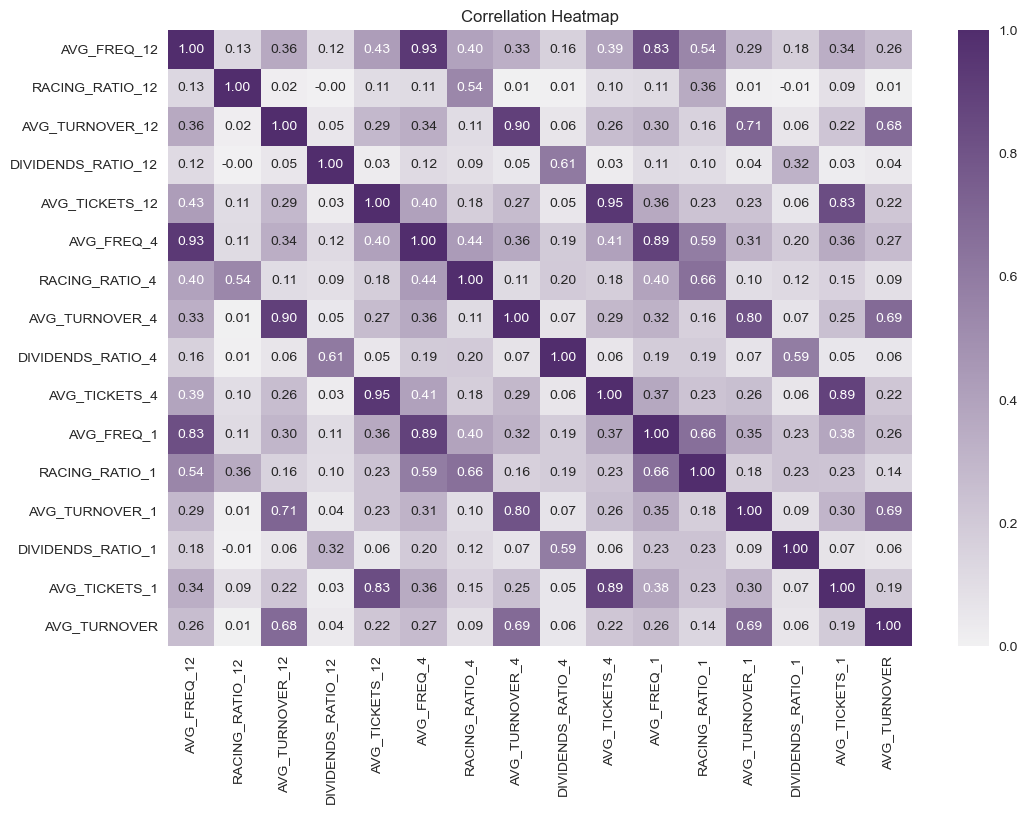

In [34]:
# Correlation matrix
corr_df = train.corr()

# Visualize
plt.figure(figsize=(12,8))

cmap = sns.light_palette("#512d6d", as_cmap=True)
sns.heatmap(corr_df, cmap=cmap, vmin=0, vmax=1 , annot=True, fmt=".2f")
plt.title("Correllation Heatmap")

plt.plot();

## 1. Linear Regression

### a. With statsmodel 

In [35]:
# Create X and y
X = train.drop('AVG_TURNOVER', axis=1)
y = train['AVG_TURNOVER']

# Choose independent variables
cat_cols = [
    'AGE_BAND', 
    'GENDER', 
    'RESIDENTIAL_STATE'
]

num_cols = [
    'AVG_FREQ_12',
    'RACING_RATIO_12',
    'AVG_TURNOVER_12',
    'DIVIDENDS_RATIO_12',
    'AVG_TICKETS_12',
    'AVG_FREQ_4',
    'RACING_RATIO_4',
    'AVG_TURNOVER_4',
    'DIVIDENDS_RATIO_4',
    'AVG_TICKETS_4',
    'AVG_FREQ_1',
    'RACING_RATIO_1',
    'AVG_TURNOVER_1',
    'DIVIDENDS_RATIO_1',
    'AVG_TICKETS_1'
]

# Transform columns
one_hot_encoder = OneHotEncoder(sparse = False)

full_pipeline = ColumnTransformer([
    ("cat", one_hot_encoder, cat_cols),
    ("num", "passthrough", num_cols),
])

# Fit model
X = full_pipeline.fit_transform(X)
y = y.values.reshape(-1,1)

# Add constant term
X = sm.add_constant(X)

# Fit model
model = sm.OLS(y, X) 
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     3246.
Date:                Fri, 14 Jul 2023   Prob (F-statistic):               0.00
Time:                        11:58:23   Log-Likelihood:            -3.8930e+05
No. Observations:               62633   AIC:                         7.787e+05
Df Residuals:                   62608   BIC:                         7.789e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4685      2.911      0.848      0.396      -3.237       8.174
x1             2.8947      5.449      0.531      0.595      -7.786      13.576
x2             0.3396      5.198      0.065      0.948      -9.848      10.527
x3             1.1117      5.181      0.215      0.830      -9.043      11.266
x4             1.5123      5.184      0.292      0.770      -8.648      11.673
x5             1.7933      5.189      0.346      0.730      -8.378      11.965
x6             1.0935      5.196      0.210      0.833      -9.090      11.277
x7            -6.2766     33.237     -0.189      0.850     -71.422      58.868
x8             0.9183      1.442      0.637      0.524      -1.909       3.745
x9             3.4847      1.180      2.954      0.003       1.172       5.797
x10           -1.9344      1.200     -1.612      0.107      -4.286       0.418
x11            1.7711      1.755      1.009      0.313      -1.670       5.212
x12            0.6975      1.611      0.433      0.665      -2.461       3.856
x13          -38.8266      5.850     -6.637      0.000     -50.292     -27.361
x14           -3.9564      2.008     -1.970      0.049      -7.893      -0.020
x15            0.4288      0.008     53.637      0.000       0.413       0.445
x16           -0.7306      0.768     -0.951      0.342      -2.236       0.775
x17            0.4691      0.090      5.221      0.000       0.293       0.645
x18           46.0382      6.928      6.645      0.000      32.459      59.617
x19            0.3745      1.706      0.220      0.826      -2.969       3.718
x20            0.0306      0.009      3.530      0.000       0.014       0.048
x21            0.2192      0.690      0.318      0.751      -1.133       1.571
x22            0.4960      0.099      5.034      0.000       0.303       0.689
x23          -11.4222      4.192     -2.725      0.006     -19.638      -3.207
x24            1.4758      1.663      0.888      0.375      -1.783       4.735
x25            0.4424      0.005     87.331      0.000       0.432       0.452
x26            0.3912      0.519      0.753      0.451      -0.627       1.409
x27           -0.8680      0.051    -17.077      0.000      -0.968      -0.768
==============================================================================
Omnibus:                   200814.812   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     106894215689.335
Skew:                          52.171   Prob(JB):                         0.00
Kurtosis:                    6402.166   Cond. No.                     1.87e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.32e-23. This might indicate

### b. With sklearn and cross validation

In [36]:
X = train.drop('AVG_TURNOVER', axis=1)
y = train['AVG_TURNOVER']

# Choose independent variables
cat_cols = [
    'AGE_BAND', 
    'GENDER', 
    'RESIDENTIAL_STATE'
]

num_cols = [
    'AVG_FREQ_12',
    'RACING_RATIO_12',
    'AVG_TURNOVER_12',
    'DIVIDENDS_RATIO_12',
    'AVG_TICKETS_12',
    'AVG_FREQ_4',
    'RACING_RATIO_4',
    'AVG_TURNOVER_4',
    'DIVIDENDS_RATIO_4',
    'AVG_TICKETS_4',
    'AVG_FREQ_1',
    'RACING_RATIO_1',
    'AVG_TURNOVER_1',
    'DIVIDENDS_RATIO_1',
    'AVG_TICKETS_1'
]

# Transform columns
one_hot_encoder = OneHotEncoder(sparse = False)

full_pipeline = ColumnTransformer([
    ("cat", one_hot_encoder, cat_cols),
    ("num", "passthrough", num_cols),
])

# Fit model
X = full_pipeline.fit_transform(X)
y = y.values.reshape(-1,1)

In [37]:
lin_reg = LinearRegression(fit_intercept=True)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(lin_reg, X, y, cv=kfold, scoring = 'neg_mean_squared_error')
scores.mean()

-15525.760066943389

In [38]:
scores

array([-10593.46287058, -62440.29568321, -16945.75089768,  -9967.79875397,
       -11155.33036122, -10930.54674497,  -8496.31208053,  -9069.81352765,
        -8596.7342115 ,  -7061.55553813])

### c. Regulization with LASSO and Ridge regression

In [45]:
# Create a model instance
lasso_reg = Lasso()
ridge_reg = Ridge()

# Define the alpha values to be tested
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# GridSearchCV
lasso_grid = GridSearchCV(estimator=Lasso(), param_grid={'alpha': alphas}, CV=10)
ridge_grid = GridSearchCV(estimator=Ridge(), param_grid={'alpha': alphas}, CV=10)

# Fit
lasso_grid.fit(X,y)
ridge_grid.fit(X,y)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [43]:
lasso_grid.best_params_['alpha']

1000

In [46]:
ridge_grid.best_params_['alpha']

1000

In [52]:
y_pred = lasso_grid.predict(X)

mean_squared_error(y, y_pred)

14818.155498343145

In [51]:
y_pred = ridge_grid.predict(X)

mean_squared_error(y, y_pred)

14675.208068468948

### c. PCA to remove multicollinearity

In [56]:
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)

pca = PCA()
pca.fit(X)

PCA()

In [57]:
pca.explained_variance_ratio_

array([0.85670938, 0.1021017 , 0.02674718, 0.01330379, 0.00088034,
       0.00019012, 0.00002788, 0.00000838, 0.00000646, 0.00000437,
       0.00000348, 0.00000248, 0.00000241, 0.00000238, 0.00000222,
       0.00000193, 0.00000185, 0.00000149, 0.00000076, 0.00000066,
       0.00000058, 0.00000014, 0.00000004, 0.        , 0.        ,
       0.        , 0.        ])

In [59]:
X_pca = pca.transform(X_scaled)[:, :2]

In [61]:
lin_reg = LinearRegression(fit_intercept=True)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(lin_reg, X_pca, y, cv=kfold, scoring = 'neg_mean_squared_error')
scores.mean()

-15547.984057126498

In [62]:
scores

array([-10658.95896332, -63809.84937531, -17085.20312482, -10235.33099154,
       -10837.68186218, -11313.20422513,  -7339.19156555,  -8742.87397846,
        -8380.33457475,  -7077.2119102 ])

# Linear Regression

In [86]:
train_1 = train.drop(['AGE_BAND', 'GENDER', 'RESIDENTIAL_STATE'],axis=1)

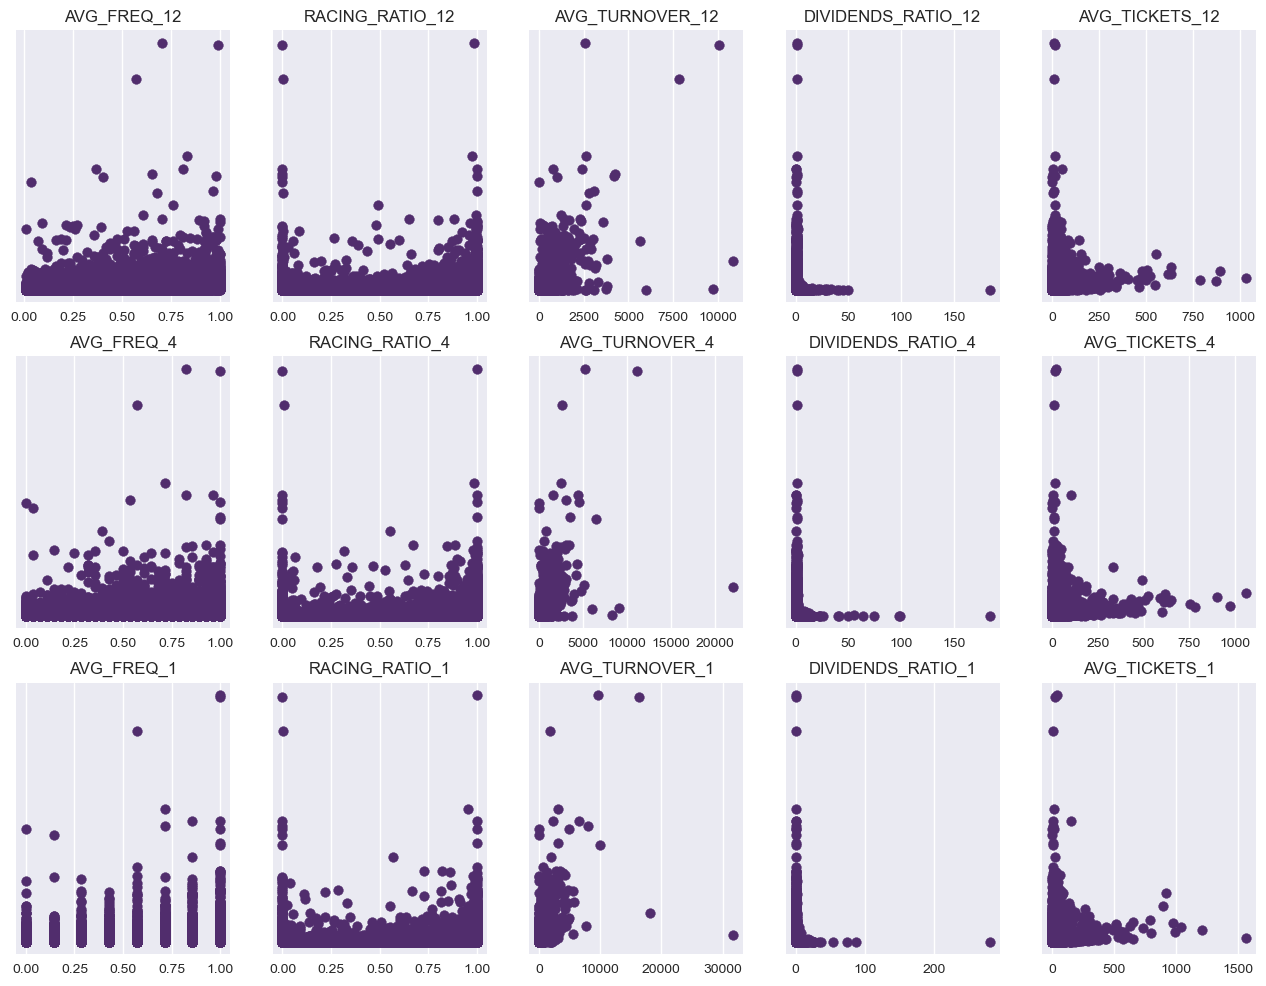

In [90]:
fig, axes = plt.subplots(3,5,figsize=(16,12))

for i in range(3):
    for j in range(5):
        axes[i,j].scatter(train_1.iloc[:,i*5 + j], train_1.iloc[:,-1])
        axes[i,j].set_title(train_1.columns[i*5+ j]) 
        axes[i,j].set_yticks([])

In [92]:
X = train_1.drop('TOTAL_TURNOVER', axis=1).to_numpy()
y = train_1['TOTAL_TURNOVER'].to_numpy().reshape(-1,1)

X = sm.add_constant(X)

model = sm.OLS(y, X) 
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     4476.
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        17:36:31   Log-Likelihood:            -3.8136e+05
No. Observations:               62116   AIC:                         7.627e+05
Df Residuals:                   62100   BIC:                         7.629e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1687      1.407      2.963      0.003       1.411       6.927
x1           -53.5505      5.352    -10.006      0.000     -64.040     -43.061
x2            -2.1859      1.787     -1.223      0.221      -5.689       1.317
x3             0.5782      0.006     97.772      0.000       0.567       0.590
x4            -0.4789      0.634     -0.755      0.450      -1.722       0.765
x5            -0.4582      0.074     -6.206      0.000      -0.603      -0.313
x6            68.7581      6.428     10.697      0.000      56.160      81.356
x7            -0.5982      1.575     -0.380      0.704      -3.684       2.488
x8            -0.0820      0.006    -12.695      0.000      -0.095      -0.069
x9             0.3782      0.546      0.693      0.488      -0.691       1.447
x10            0.7475      0.084      8.874      0.000       0.582       0.913
x11           31.0227      3.896      7.962      0.000      23.386      38.660
x12           -4.8001      1.530     -3.138      0.002      -7.798      -1.802
x13            0.1828      0.003     53.974      0.000       0.176       0.189
x14            0.2183      0.319      0.683      0.494      -0.408       0.844
x15            0.0295      0.040      0.731      0.465      -0.050       0.109
==============================================================================
Omnibus:                    88246.710   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3783229951.013
Skew:                           6.824   Prob(JB):                         0.00
Kurtosis:                    1211.948   Cond. No.                     5.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Scatter plot: Error vs. Predicted turnover')

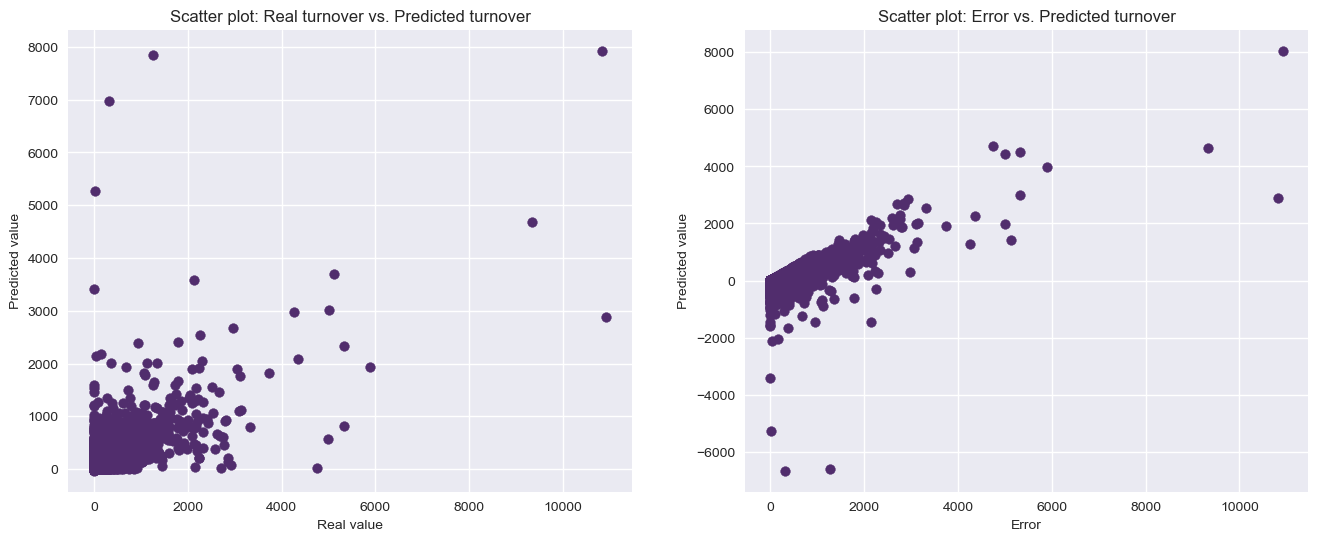

In [93]:
y_pred = results.predict(X)
e =y.flatten() -y_pred

# Visualize
fig, axes = plt.subplots(1,2, figsize=(16,6))

axes[0].scatter(y, y_pred)
axes[0].set_xlabel("Real value")
axes[0].set_ylabel("Predicted value")
axes[0].set_title("Scatter plot: Real turnover vs. Predicted turnover") 

axes[1].scatter(y, e)
axes[1].set_xlabel("Error")
axes[1].set_ylabel("Predicted value")
axes[1].set_title("Scatter plot: Error vs. Predicted turnover") 

In [94]:
sum(e**2)/62116

12594.459813416179

---------------------------

In [81]:
train_2 = train.drop(['TENURE_IN_DAYS_1', 'TENURE_IN_DAYS_4','TENURE_IN_DAYS_12',
    'RACING_RATIO_12', 'DIVIDENDS_RATIO_12', 'RACING_RATIO_4', 'DIVIDENDS_RATIO_4', 'DIVIDENDS_RATIO_1', 'AVG_TICKETS_1'],axis=1)

In [82]:
X = train_2.drop('TOTAL_TURNOVER', axis=1).to_numpy()
y = train_2['TOTAL_TURNOVER'].to_numpy().reshape(-1,1)

X = sm.add_constant(X)

model = sm.OLS(y, X) 
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     7459.
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        14:44:43   Log-Likelihood:            -3.8136e+05
No. Observations:               62116   AIC:                         7.627e+05
Df Residuals:                   62106   BIC:                         7.628e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2050      0.709      3.108      0.002       0.814       3.595
x1           -53.5995      5.321    -10.074      0.000     -64.028     -43.171
x2             0.5785      0.006     97.885      0.000       0.567       0.590
x3            -0.4729      0.072     -6.535      0.000      -0.615      -0.331
x4            67.6957      6.206     10.907      0.000      55.531      79.860
x5            -0.0825      0.006    -12.874      0.000      -0.095      -0.070
x6             0.7861      0.067     11.788      0.000       0.655       0.917
x7            32.8169      3.695      8.883      0.000      25.576      40.058
x8            -5.7656      1.225     -4.705      0.000      -8.167      -3.364
x9             0.1832      0.003     54.978      0.000       0.177       0.190
==============================================================================
Omnibus:                    88207.254   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3784784176.191
Skew:                           6.817   Prob(JB):                         0.00
Kurtosis:                    1212.196   Cond. No.                     5.60e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Scatter plot: Error vs. Predicted turnover')

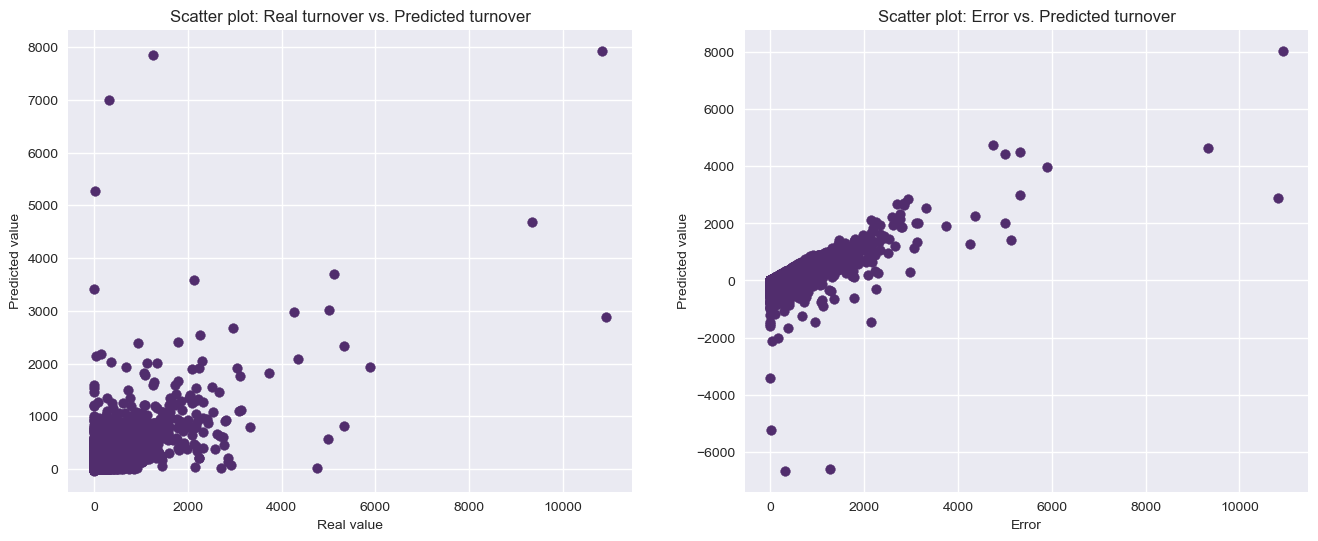

In [83]:
y_pred = results.predict(X)
e =y.flatten() -y_pred

# Visualize
fig, axes = plt.subplots(1,2, figsize=(16,6))

axes[0].scatter(y, y_pred)
axes[0].set_xlabel("Real value")
axes[0].set_ylabel("Predicted value")
axes[0].set_title("Scatter plot: Real turnover vs. Predicted turnover") 

axes[1].scatter(y, e)
axes[1].set_xlabel("Error")
axes[1].set_ylabel("Predicted value")
axes[1].set_title("Scatter plot: Error vs. Predicted turnover") 

In [85]:
sum(e**2)/62116

12595.33988046882

--------------------------

In [116]:
train_3 = train[[
    'AVG_TURNOVER_1',
    'AVG_TURNOVER_4',
    'AVG_TURNOVER_12',
    'AVG_TICKETS_12',
    'AVG_TICKETS_4',
    'AVG_TICKETS_1',
    'TOTAL_TURNOVER'
]]
train_3 = np.log(train_3+1)

In [117]:
X = train_3.drop('TOTAL_TURNOVER', axis=1).to_numpy()
y = train_3['TOTAL_TURNOVER'].to_numpy().reshape(-1,1)

X = sm.add_constant(X)

model = sm.OLS(y, X) 
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                 2.820e+04
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:00:31   Log-Likelihood:                -84569.
No. Observations:               62116   AIC:                         1.692e+05
Df Residuals:                   62109   BIC:                         1.692e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0647      0.007      9.799      0.000       0.052       0.078
x1             0.3080      0.007     44.521      0.000       0.294       0.322
x2             0.3002      0.009     32.499      0.000       0.282       0.318
x3             0.2802      0.008     37.199      0.000       0.265       0.295
x4             0.1642      0.016     10.298      0.000       0.133       0.195
x5             0.0375      0.020      1.865      0.062      -0.002       0.077
x6            -0.1149      0.014     -8.324      0.000      -0.142      -0.088
==============================================================================
Omnibus:                     5655.630   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40920.373
Skew:                          -0.027   Prob(JB):                         0.00
Kurtosis:                       6.976   Cond. No.                         35.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Scatter plot: Error vs. Predicted turnover')

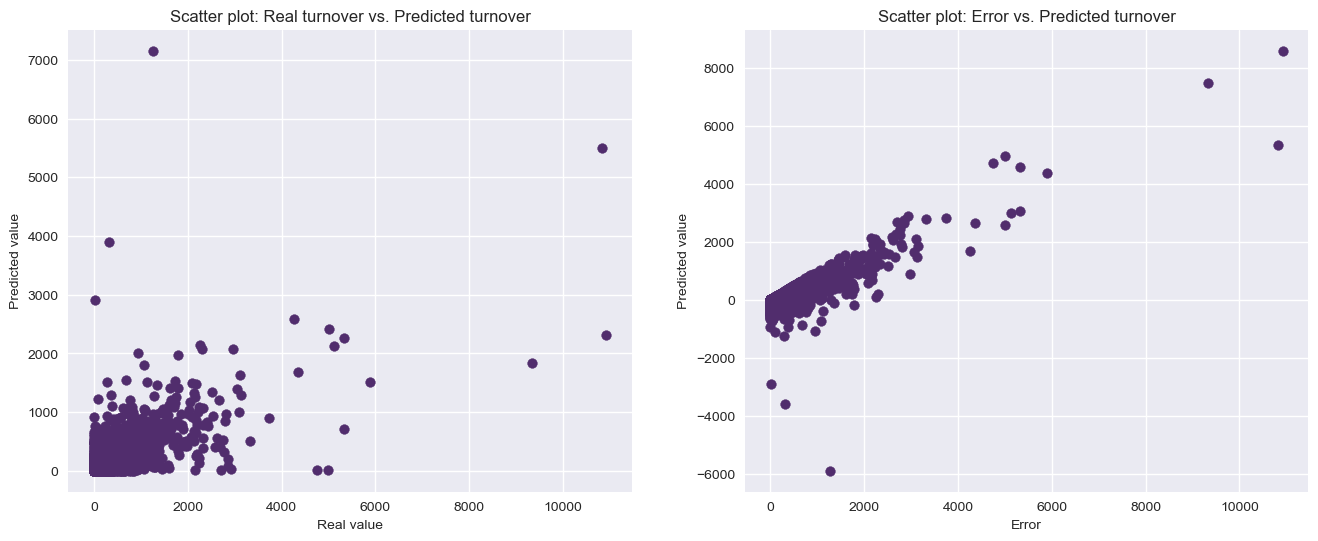

In [128]:
y_pred = np.exp(results.predict(X))-1
e = train['TOTAL_TURNOVER'].values - y_pred

# Visualize
fig, axes = plt.subplots(1,2, figsize=(16,6))

axes[0].scatter(train['TOTAL_TURNOVER'].values, y_pred)
axes[0].set_xlabel("Real value")
axes[0].set_ylabel("Predicted value")
axes[0].set_title("Scatter plot: Real turnover vs. Predicted turnover") 

axes[1].scatter(train['TOTAL_TURNOVER'].values, e)
axes[1].set_xlabel("Error")
axes[1].set_ylabel("Predicted value")
axes[1].set_title("Scatter plot: Error vs. Predicted turnover") 

In [129]:
sum(e**2)/62116

12989.15556105358

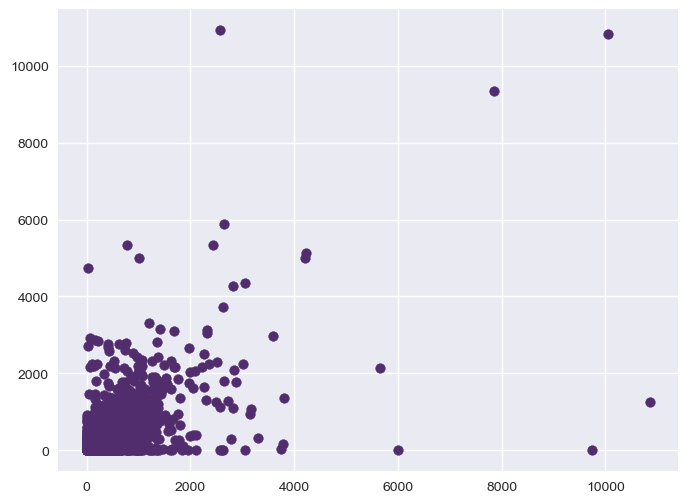

In [157]:
plt.figure(figsize=(8,6))
plt.scatter(train['AVG_TURNOVER_12'],train['TOTAL_TURNOVER'])

# Regression tree

In [108]:
X = train.drop('AVG_TURNOVER', axis=1)
y = train['AVG_TURNOVER']

# Choose independent variables
cat_cols = [
    'AGE_BAND', 
    'GENDER', 
    'RESIDENTIAL_STATE'
]

num_cols = [
    'AVG_FREQ_12',
    'RACING_RATIO_12',
    'AVG_TURNOVER_12',
    'DIVIDENDS_RATIO_12',
    'AVG_TICKETS_12',
    'AVG_FREQ_4',
    'RACING_RATIO_4',
    'AVG_TURNOVER_4',
    'DIVIDENDS_RATIO_4',
    'AVG_TICKETS_4',
    'AVG_FREQ_1',
    'RACING_RATIO_1',
    'AVG_TURNOVER_1',
    'DIVIDENDS_RATIO_1',
    'AVG_TICKETS_1'
]

# Transform columns
one_hot_encoder = OneHotEncoder(sparse = False)

full_pipeline = ColumnTransformer([
    ("cat", one_hot_encoder, cat_cols),
    ("num", "passthrough", num_cols),
])

# Fit model
X = full_pipeline.fit_transform(X)
y = y.values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [109]:
tree_reg = DecisionTreeRegressor()

param_grid = {
    'max_depth' : range(3,11),
    'min_weight_fraction_leaf' : [0.03,0.05,0.10]
}

grid_search = GridSearchCV(estimator=tree_reg, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(3, 11),
                         'min_weight_fraction_leaf': [0.03, 0.05, 0.1]})

In [110]:
grid_search.best_params_

{'max_depth': 10, 'min_weight_fraction_leaf': 0.03}

In [113]:
tree_reg = DecisionTreeRegressor(**grid_search.best_params_)

tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, min_weight_fraction_leaf=0.03)

In [120]:
y_pred = tree_reg.predict(X_test)
mean_squared_error(y_pred, y_test)

13405.274694964166

In [121]:
y_pred = tree_reg.predict(X_train)
mean_squared_error(y_pred, y_train)

21523.852765403866

# Random forest

In [123]:
rf_reg = RandomForestRegressor(n_estimators=500, max_depth= 10, min_weight_fraction_leaf= 0.05, random_state=42)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_weight_fraction_leaf=0.05,
                      n_estimators=500, random_state=42)

In [124]:
y_pred = rf_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

14406.598193263415

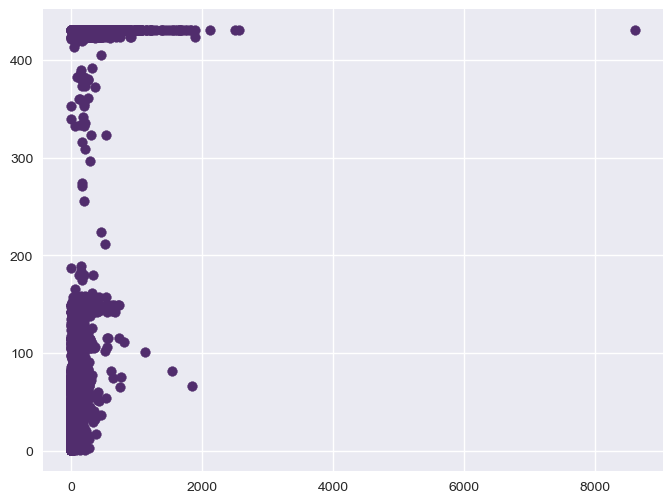

In [125]:
plt.figure(figsize=(8,6))
plt.scatter(y_test,y_pred)

In [128]:
year_week=202134
train = total_aggregate(df, year_week)

# Join with cus_df to get categorical data
train = pd.merge(train, cus_df, left_index=True, right_index=True, how='left')

In [129]:
X = train.drop('AVG_TURNOVER', axis=1)
y = train['AVG_TURNOVER']

# Choose independent variables
cat_cols = [
    'AGE_BAND', 
    'GENDER', 
    'RESIDENTIAL_STATE'
]

num_cols = [
    'AVG_FREQ_12',
    'RACING_RATIO_12',
    'AVG_TURNOVER_12',
    'DIVIDENDS_RATIO_12',
    'AVG_TICKETS_12',
    'AVG_FREQ_4',
    'RACING_RATIO_4',
    'AVG_TURNOVER_4',
    'DIVIDENDS_RATIO_4',
    'AVG_TICKETS_4',
    'AVG_FREQ_1',
    'RACING_RATIO_1',
    'AVG_TURNOVER_1',
    'DIVIDENDS_RATIO_1',
    'AVG_TICKETS_1'
]

# Transform columns
one_hot_encoder = OneHotEncoder(sparse = False)

full_pipeline = ColumnTransformer([
    ("cat", one_hot_encoder, cat_cols),
    ("num", "passthrough", num_cols),
])

# Fit model
X = full_pipeline.fit_transform(X)
y = y.values.reshape(-1,1)

In [133]:
y_test = train['AVG_TURNOVER']

In [132]:
y_pred = rf_reg.predict(X)

In [134]:
mean_squared_error(y_test,y_pred)

27111.513733041007

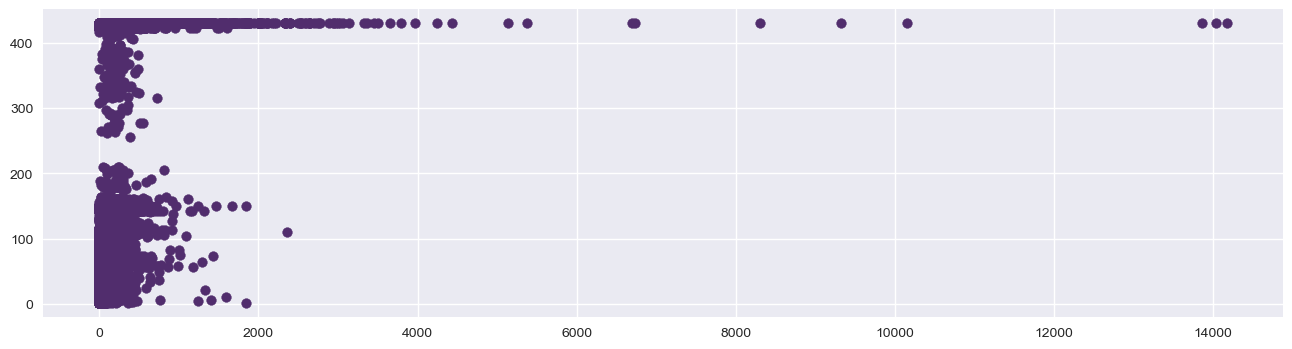

In [135]:
plt.scatter(y_test,y_pred)